In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
import glob
import re
import itertools
import time
import joblib
import random
import itertools
import pickle

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
pd.options.display.precision = 3
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import matplotlib.pyplot as plt
from matplotlib import container
from matplotlib.lines import Line2D

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
#from polyfuse.configs.igsb_jupyter import config
parsl.load(config)

from polyfuse import apps, transformations

In [16]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/cancer_cell_lines/processed'
model_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/models'

In [28]:
samples_and_fusions = [
    ('BT474', 'ACACA--STAC2'),
    ('BT474', 'AHCTF1--NAAA'),
    ('BT474', 'CPNE1--PI3'),
    ('BT474', 'DIDO1--TTI1'),
    ('BT474', 'FAM102A--CIZ1'),
    ('BT474', 'GLB1--CMTM7'),
    ('BT474', 'LAMP1--MCF2L'),
    ('BT474', 'LIMA1--USP22'),
    ('BT474', 'MED1--ACSF2'),
    ('BT474', 'MED1--STXBP4'),
    ('BT474', 'MED13--BCAS3'),
    ('BT474', 'PIP4K2B--RAD51C'),
    ('BT474', 'RAB22A--MYO9B'),
    ('BT474', 'RPS6KB1--SNF8'),
    ('BT474', 'SKA2--MYO19'),
    ('BT474', 'STARD3--DOK5'),
    ('BT474', 'STX16--RAE1'),
    ('BT474', 'THRA--AC090627.1'),
    ('BT474', 'TOB1--SYNRG'),
    ('BT474', 'TRPC4AP--MRPL45'),
    ('BT474', 'USP32--MED1'),
    ('BT474', 'VAPB--IKZF3'),
    ('BT474', 'ZMYND8--CEP250'),
    ('KPL4', 'BSG--NFIX'),
    ('KPL4', 'NOTCH1--NUP214'),
    ('KPL4', 'PPP1R12A--SEPT10'),
    ('MCF7', 'AC099850.1--VMP1'),
    ('MCF7', 'ADAMTS19--SLC27A6'),
    ('MCF7', 'AHCYL1--RAD51C'),
    ('MCF7', 'ARFGEF2--SULF2'),
    ('MCF7', 'ARHGAP19--DRG1'),
    ('MCF7', 'ATXN7L3--FAM171A2'),
    ('MCF7', 'BCAS4--BCAS3'),
    ('MCF7', 'GCN1L1--MSI1'),
    ('MCF7', 'MYH9--EIF3D'),
    ('MCF7', 'MYO9B--FCHO1'),
    ('MCF7', 'PAPOLA--AK7'),
    ('MCF7', 'RPS6KB1--DIAPH3'),
    ('MCF7', 'RPS6KB1--VMP1'),
    ('MCF7', 'SMARCA4--CARM1'),
    ('MCF7', 'SULF2--PRICKLE2'),
    ('SKBR3', 'ANKHD1--PCDH1'),
    ('SKBR3', 'CCDC85C--SETD3'),
    ('SKBR3', 'CSE1L--AL035685.1'),
    ('SKBR3', 'CYTH1--EIF3H'),
    ('SKBR3', 'DHX35--ITCH'),
    ('SKBR3', 'KLHDC2--SNTB1'),
    ('SKBR3', 'NFS1--PREX1'),
    ('SKBR3', 'PREX1--CPNE1'),
    ('SKBR3', 'RARA--PKIA'),
    ('SKBR3', 'SUMF1--LRRFIP2'),
    ('SKBR3', 'TATDN1--GSDMB'),
    ('SKBR3', 'WDR67--ZNF704')
]

truth = pd.DataFrame(data={
    'sample': [e[0] for e in samples_and_fusions],
    'fusion': [e[1] for e in samples_and_fusions]
    }
)
truth.to_hdf(os.path.join(out_dir, 'true_fusions.hdf'), 'data')

In [5]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly', 'mapsplice2']

In [6]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [7]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [8]:
samples = sorted(caller_data['sample'].unique())

In [11]:
start = time.time()
x = apps.assemble_data(samples, callers, out_dir, assemble_truth=False)
print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 16.3s


In [49]:
start = time.time()
with open(os.path.join(model_dir, 'classifiers.pkl'), 'rb') as f:
    classifiers = pickle.load(f)

consensus_data = pd.read_hdf(
    apps.predict_consensus(samples, out_dir, callers, [3, 4, 5, 6, 7]), 'data'
)
print('assembled consensus predictions in {:.1f}s'.format((time.time() - start)))

start = time.time()
consensus = ['ConsensusQ5', 'ConsensusQ4', 'ConsensusQ3']
model_data = pd.read_hdf(
    apps.predict(samples, out_dir, model_dir, classifiers, callers, consensus=consensus), 'data'
)
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled consensus predictions in 7.2s
assembled predictions in 17.2s


In [50]:
pd.options.display.max_rows = None
model_data[(model_data.caller == 'PolyfuseGBC19F') & (model_data.prediction == 1)]

,sample,caller,fusion,probability,prediction
21,BT474,PolyfuseGBC19F,"RB1CC1--PDCL2P2(1875),SPDYC(7897)",0.625,1
28,BT474,PolyfuseGBC19F,STX16--RAE1,0.872,1
38,BT474,PolyfuseGBC19F,AC025048.4--HEATR6,0.829,1
40,BT474,PolyfuseGBC19F,TOB1--SYNRG,0.952,1
45,BT474,PolyfuseGBC19F,MED13--BCAS3,0.961,1
65,BT474,PolyfuseGBC19F,TRIM37--MYO19,0.698,1
102,BT474,PolyfuseGBC19F,GLB1--CMTM7,0.895,1
118,BT474,PolyfuseGBC19F,USP32--MED1,0.732,1
121,BT474,PolyfuseGBC19F,LAMP1--MCF2L,0.981,1
125,BT474,PolyfuseGBC19F,LIMA1--USP22,0.803,1


In [51]:
summary = apps.make_summary(out_dir, samples)

In [ ]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure(figsize=(8, 9))
    #plt.figure()
    #sorted_index = summary[metric].median().sort_values().index
    #print(sorted_index)
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

In [ ]:
sns.set_context('paper', font_scale=1.8)
filter_regex = 'PolyfuseDefaultGBC17F|PolyfuseDefaultGBC19F|PolyfuseGBC17F|ConsensusQ3|ConsensusQ4'
top_model_summary = summary[~summary.caller.str.contains(filter_regex)]
means = top_model_summary.groupby('caller').mean()
stds = top_model_summary.groupby('caller').std()

#markers = itertools.cycle(Line2D.filled_markers)
markers = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D'))
markers = itertools.cycle(Line2D.filled_markers[:len(means)])
sns.set_palette(sns.diverging_palette(145, 280, s=85, l=25, n=8, center='dark'))
sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=9, center='dark'))
sns.set_palette("husl")

for x, y in [('recall', 'precision'), ('accuracy', 'f1')]:
    fig, ax = plt.subplots(figsize=(11, 5))

    for caller in means.index:
        plt.errorbar(
            [means.loc[caller][x]],
            [means.loc[caller][y]],
            xerr=stds.loc[caller][x],
            yerr=stds.loc[caller][y],
            label=caller,
            marker=next(markers),
            markersize=10,
            capsize=3
        )
        
    plt.xlabel(x)
    plt.ylabel(y)
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), frameon=False)
    #plt.tight_layout()
    plt.savefig('plots/{}_vs_{}.pdf'.format(x, y))
    

In [53]:
pd.options.display.max_rows = None
summary.groupby('caller').mean().sort_values(by='tp', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
ConsensusQ3PolyfuseGBC19F,12.75,10.50,0.50,339.00,0.967,0.500,0.965,0.639,0.669
ConsensusQ3PolyfuseDefaultGBC19F,12.75,9.75,0.50,339.75,0.967,0.516,0.967,0.653,0.681
ConsensusQ5PolyfuseGBC19F,12.00,8.50,1.25,341.00,0.918,0.536,0.970,0.664,0.681
PolyfuseDefaultGBC19F,12.00,8.50,1.25,341.00,0.918,0.532,0.970,0.653,0.674
ConsensusQ4PolyfuseDefaultGBC19F,12.00,9.25,1.25,340.25,0.918,0.514,0.967,0.637,0.660
ConsensusQ4PolyfuseGBC19F,12.00,8.75,1.25,340.75,0.918,0.528,0.969,0.654,0.674
PolyfuseGBC19F,12.00,8.25,1.25,341.25,0.918,0.542,0.971,0.668,0.685
ConsensusQ5PolyfuseDefaultGBC19F,12.00,8.75,1.25,340.75,0.918,0.525,0.969,0.649,0.670
starfusion,10.00,9.25,3.25,340.25,0.716,0.457,0.961,0.544,0.546


In [62]:
pd.options.display.max_rows = None
for sample in samples:
    print(summary.loc[summary['sample'] == sample, ['sample', 'caller', 'tp', 'fn']].sort_values(by='tp', ascending=False))

   sample                            caller  tp  fn
12  BT474  ConsensusQ3PolyfuseGBC19F         23  0 
28  BT474  ConsensusQ3PolyfuseDefaultGBC19F  23  0 
0   BT474  PolyfuseGBC19F                    22  1 
8   BT474  ConsensusQ4PolyfuseGBC19F         22  1 
16  BT474  PolyfuseDefaultGBC19F             22  1 
20  BT474  ConsensusQ5PolyfuseDefaultGBC19F  22  1 
24  BT474  ConsensusQ4PolyfuseDefaultGBC19F  22  1 
4   BT474  ConsensusQ5PolyfuseGBC19F         22  1 
56  BT474  ConsensusQ3                       21  2 
44  BT474  starfusion                        21  2 
36  BT474  starseqr                          20  3 
48  BT474  arriba                            20  3 
52  BT474  pizzly                            20  3 
60  BT474  ConsensusQ4                       19  4 
32  BT474  fusioncatcher                     17  6 
64  BT474  ConsensusQ5                       17  6 
40  BT474  mapsplice2                        15  8 
   sample                            caller  tp  fn
1   KPL4   P

PolyfuseRFC10F
PolyfuseGBC10F
PolyfuseDefaultGBC10F
PolyfuseRFC15F
PolyfuseGBC15F
PolyfuseDefaultGBC15F


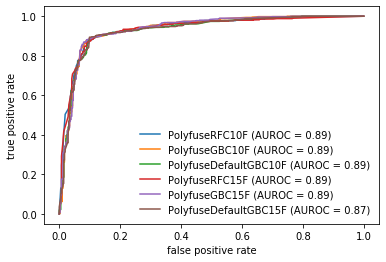

In [77]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)

PolyfuseRFC4F
PolyfuseGBC4F
PolyfuseDefaultGBC4F
PolyfuseRFC7F
PolyfuseGBC7F
PolyfuseDefaultGBC7F


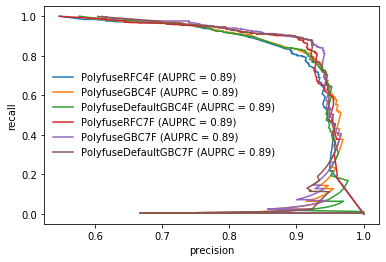

In [27]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

In [21]:
from sklearn.feature_selection import RFECV
#classifier = joblib.load(os.path.join(out_dir, 'models/GBC22F.joblib'))
start = time.time()
classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250, subsample=1.)
classifier.fit(x_train, y_train)


cv_selector = RFECV(classifier, cv=5, step=1, scoring='recall', n_jobs=-1)
cv_selector = cv_selector.fit(x_train, y_train)
                         
rfecv_features = [feature for support, feature in zip(cv_selector.get_support(), x_train.columns) if support]
print('Optimal number of features:', cv_selector.n_features_)
print('Best features:', rfecv_features)


Optimal number of features: 19
Best features: ['starseqr_called', 'starseqr_spanning_reads', 'starseqr_junction_reads', 'starfusion_spanning_reads', 'starfusion_junction_reads', 'arriba_spanning_reads', 'fusioncatcher_called', 'fusioncatcher_spanning_reads', 'fusioncatcher_junction_reads', 'pizzly_called', 'pizzly_spanning_reads', 'pizzly_junction_reads', 'mapsplice2_spanning_reads', 'mapsplice2_junction_reads', 'FFPM', 'RightBreakEntropy', 'coverage1', 'coverage2', 'arriba_confidence_low']


NameError: name 'cv_estimator' is not defined

<Figure size 576x576 with 0 Axes>

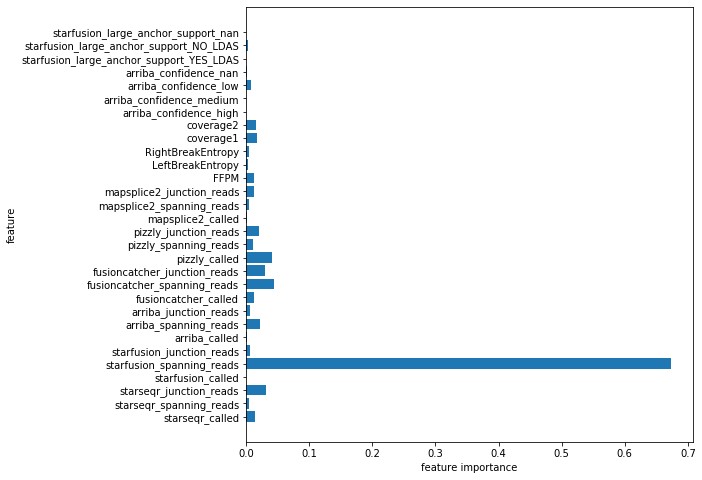

calculated best features in 3502.6s


In [22]:
n_features = x_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), classifier.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), x_train.columns.values) 
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()
print('calculated best features in {:.1f}s'.format(time.time() - start))

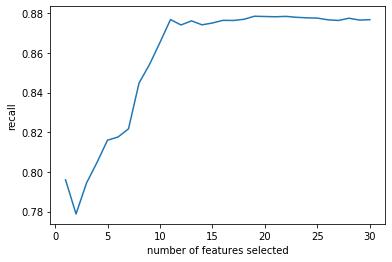

In [60]:
plt.figure()
plt.xlabel("number of features selected")
plt.ylabel("recall")
plt.plot(range(1, len(cv_selector.grid_scores_) + 1), cv_selector.grid_scores_)
plt.show()

In [ ]:
start = time.time()
cv_selector = RFECV(classifier, cv=5, step=1, scoring='accuracy', n_jobs=-1)
cv_selector = cv_selector.fit(x_train, y_train)
                         
rfecv_features = [feature for support, feature in zip(cv_selector.get_support(), x_train.columns) if support]
print('Optimal number of features:', cv_selector.n_features_)
print('Best features:', rfecv_features)
n_features = x_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), x_train.columns.values) 
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()
print('calculated best features in {:.1f}s'.format(time.time() - start))

In [52]:
x_train

,FFPM,LargeAnchorSupport,LeftBreakEntropy,RightBreakEntropy,arriba_called,arriba_confidence_high,arriba_confidence_low,arriba_confidence_medium,arriba_confidence_nan,arriba_junction_reads,arriba_spanning_reads,confidence,coverage1,coverage2,fusioncatcher_called,fusioncatcher_junction_reads,fusioncatcher_spanning_reads,mapsplice2_called,mapsplice2_junction_reads,mapsplice2_spanning_reads,pizzly_called,pizzly_junction_reads,pizzly_spanning_reads,starfusion_called,starfusion_junction_reads,starfusion_large_anchor_support_NO_LDAS,starfusion_large_anchor_support_YES_LDAS,starfusion_large_anchor_support_nan,starfusion_spanning_reads,starseqr_called,starseqr_junction_reads,starseqr_spanning_reads
0,0.800,NaN,1.690,1.832,1,1.0,0.0,0.0,0.0,6.0,19.0,NaN,51.0,27.0,1,5.0,19.0,1,7.0,22.0,1,13.0,2.0,1,5.0,0.0,1.0,0.0,19.0,1,6.0,19.0
1,0.000,NaN,0.000,0.000,1,1.0,0.0,0.0,0.0,6.0,47.0,NaN,181.0,34.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
2,21.900,NaN,1.933,1.933,1,1.0,0.0,0.0,0.0,126.0,300.0,NaN,2038.0,655.0,1,25.0,457.0,1,304.0,778.0,1,407.0,130.0,1,153.0,0.0,1.0,0.0,504.0,1,137.0,429.0
3,5.000,NaN,1.966,1.889,1,1.0,0.0,0.0,0.0,23.0,113.0,NaN,129.0,113.0,1,19.0,114.0,1,38.0,210.0,1,104.0,28.0,1,24.0,0.0,1.0,0.0,126.0,1,22.0,125.0
4,90.833,NaN,1.922,1.829,1,1.0,0.0,0.0,0.0,420.0,300.0,NaN,1534.0,1530.0,1,25.0,2040.0,1,1086.0,3248.0,1,1777.0,472.0,1,647.0,0.0,1.0,0.0,2078.0,1,425.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,0.000,NaN,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,1,19.0,81.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1008,0.000,NaN,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,714.0,241.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1009,0.000,NaN,0.000,0.000,1,1.0,0.0,0.0,0.0,8.0,26.0,NaN,92.0,33.0,0,0.0,0.0,0,0.0,0.0,1,24.0,10.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1010,0.000,NaN,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,136.0,37.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0


In [54]:
x_train.fillna(0)

,FFPM,LargeAnchorSupport,LeftBreakEntropy,RightBreakEntropy,arriba_called,arriba_confidence_high,arriba_confidence_low,arriba_confidence_medium,arriba_confidence_nan,arriba_junction_reads,arriba_spanning_reads,confidence,coverage1,coverage2,fusioncatcher_called,fusioncatcher_junction_reads,fusioncatcher_spanning_reads,mapsplice2_called,mapsplice2_junction_reads,mapsplice2_spanning_reads,pizzly_called,pizzly_junction_reads,pizzly_spanning_reads,starfusion_called,starfusion_junction_reads,starfusion_large_anchor_support_NO_LDAS,starfusion_large_anchor_support_YES_LDAS,starfusion_large_anchor_support_nan,starfusion_spanning_reads,starseqr_called,starseqr_junction_reads,starseqr_spanning_reads
0,0.800,0,1.690,1.832,1,1.0,0.0,0.0,0.0,6.0,19.0,0,51.0,27.0,1,5.0,19.0,1,7.0,22.0,1,13.0,2.0,1,5.0,0.0,1.0,0.0,19.0,1,6.0,19.0
1,0.000,0,0.000,0.000,1,1.0,0.0,0.0,0.0,6.0,47.0,0,181.0,34.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
2,21.900,0,1.933,1.933,1,1.0,0.0,0.0,0.0,126.0,300.0,0,2038.0,655.0,1,25.0,457.0,1,304.0,778.0,1,407.0,130.0,1,153.0,0.0,1.0,0.0,504.0,1,137.0,429.0
3,5.000,0,1.966,1.889,1,1.0,0.0,0.0,0.0,23.0,113.0,0,129.0,113.0,1,19.0,114.0,1,38.0,210.0,1,104.0,28.0,1,24.0,0.0,1.0,0.0,126.0,1,22.0,125.0
4,90.833,0,1.922,1.829,1,1.0,0.0,0.0,0.0,420.0,300.0,0,1534.0,1530.0,1,25.0,2040.0,1,1086.0,3248.0,1,1777.0,472.0,1,647.0,0.0,1.0,0.0,2078.0,1,425.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,0.000,0,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1,19.0,81.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1008,0.000,0,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,714.0,241.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1009,0.000,0,0.000,0.000,1,1.0,0.0,0.0,0.0,8.0,26.0,0,92.0,33.0,0,0.0,0.0,0,0.0,0.0,1,24.0,10.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1010,0.000,0,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,136.0,37.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0


In [153]:
sample = 'LIB-04650wt'
data = pd.read_hdf(os.path.join(out_dir, 'caller_data.hdf'))
cut_data = data.loc[data['sample'] == sample]

In [25]:
consensus_data_path = apps.predict_consensus(samples, out_dir, callers, [3, 4, 5, 6, 7])

In [26]:
consensus_data = pd.read_hdf(consensus_data_path)

In [27]:
consensus_data

,sample,caller,fusion
0,LIB-006798wt,ConsensusQ3,RPP40--RCN2
1,LIB-006798wt,ConsensusQ3,AFAP1L1--PFKFB1
2,LIB-006798wt,ConsensusQ3,DUSP2--PKP1
3,LIB-006798wt,ConsensusQ3,C10orf142--GLYATL1B
4,LIB-006798wt,ConsensusQ3,LDHB--PRR14L
...,...,...,...
102127,LIB-04674wt,ConsensusQ5,NF2--WWTR1
102128,LIB-04674wt,ConsensusQ5,CASP10--ASB15
102129,LIB-04674wt,ConsensusQ5,IGDCC3--CPAMD8
102130,LIB-04674wt,ConsensusQ5,NKAPD1--HEATR1


In [29]:
sample = 'LIB-04674wt'
consensus = 'ConsensusQ5'
consensus_data.loc[(consensus_data['sample'] == sample) & (consensus_data.caller == consensus)]

,sample,caller,fusion
101750,LIB-04674wt,ConsensusQ5,FANCA--ADAM23
101751,LIB-04674wt,ConsensusQ5,PALD1--SLURP2
101752,LIB-04674wt,ConsensusQ5,PGLYRP1--COL5A1
101753,LIB-04674wt,ConsensusQ5,VEGFB--ARHGAP28
101754,LIB-04674wt,ConsensusQ5,RFX8--MPHOSPH8
...,...,...,...
102127,LIB-04674wt,ConsensusQ5,NF2--WWTR1
102128,LIB-04674wt,ConsensusQ5,CASP10--ASB15
102129,LIB-04674wt,ConsensusQ5,IGDCC3--CPAMD8
102130,LIB-04674wt,ConsensusQ5,NKAPD1--HEATR1


In [35]:
from polyfuse.utils import get_consensus

data = pd.read_hdf(os.path.join(out_dir, 'caller_data.hdf'))
cut_data = data.loc[data['sample'] == sample]
callsets = []
futures = []
for caller in callers:
    callsets.append(set(cut_data[cut_data.caller == caller].fusion))
for quorum in [1, 2, 3, 4, 5, 6, 7]:
    futures += [(get_consensus(callsets, quorum), quorum)]

In [36]:
for f, quorum in futures:
    consensus = f.result()
    print(len(consensus), quorum)

930 1
569 2
477 3
439 4
382 5
0 6
0 7


In [13]:
all_caller_data = pd.read_hdf(os.path.join(out_dir, 'all_caller_data.hdf'), 'data')

In [14]:
all_caller_data.shape

(247096, 171)

In [15]:
all_caller_data

,gene1,gene2,fusioncatcher_Fusion_description,fusioncatcher_Counts_of_common_mapping_reads,fusioncatcher_Spanning_pairs,fusioncatcher_Spanning_unique_reads,fusioncatcher_Longest_anchor_found,fusioncatcher_Fusion_finding_method,fusioncatcher_Fusion_point_for_gene_1(5end_fusion_partner),fusioncatcher_Fusion_point_for_gene_2(3end_fusion_partner),fusioncatcher_Gene_1_id(5end_fusion_partner),fusioncatcher_Gene_2_id(3end_fusion_partner),fusioncatcher_Exon_1_id(5end_fusion_partner),fusioncatcher_Exon_2_id(3end_fusion_partner),fusioncatcher_Fusion_sequence,fusioncatcher_Predicted_effect,fusioncatcher_fusion,spanning_reads,junction_reads,caller,sample,starseqr_NAME,starseqr_NREAD_SPANS,starseqr_NREAD_JXNLEFT,starseqr_NREAD_JXNRIGHT,starseqr_FUSION_CLASS,starseqr_SPLICE_TYPE,starseqr_BRKPT_LEFT,starseqr_BRKPT_RIGHT,starseqr_LEFT_SYMBOL,starseqr_RIGHT_SYMBOL,starseqr_ANNOT_FORMAT,starseqr_LEFT_ANNOT,starseqr_RIGHT_ANNOT,starseqr_DISTANCE,starseqr_ASSEMBLED_CONTIGS,starseqr_ASSEMBLY_CROSS_JXN,starseqr_PRIMERS,starseqr_ID,starseqr_SPAN_CROSSHOM_SCORE,starseqr_JXN_CROSSHOM_SCORE,starseqr_OVERHANG_DIVERSITY,starseqr_MINFRAG20,starseqr_MINFRAG35,starseqr_OVERHANG_MEANBQ,starseqr_SPAN_MEANBQ,starseqr_JXN_MEANBQ,starseqr_OVERHANG_BQ15,starseqr_SPAN_BQ15,starseqr_JXN_BQ15,starseqr_OVERHANG_MM,starseqr_SPAN_MM,starseqr_JXN_MM,starseqr_OVERHANG_MEANLEN,starseqr_SPAN_MEANLEN,starseqr_JXN_MEANLEN,starseqr_TPM_FUSION,starseqr_TPM_LEFT,starseqr_TPM_RIGHT,starseqr_MAX_TRX_FUSION,starseqr_DISPOSITION,starseqr_chromosome1,starseqr_chromosome2,starseqr_breakpoint1,starseqr_breakpoint2,mapsplice2_chrom,mapsplice2_doner_end,mapsplice2_acceptor_start,mapsplice2_id,mapsplice2_coverage,mapsplice2_strand,mapsplice2_rgb,mapsplice2_block_count,mapsplice2_block_size,mapsplice2_block_distance,mapsplice2_entropy,mapsplice2_flank_case,mapsplice2_flank_string,mapsplice2_min_mismatch,mapsplice2_max_mismatch,mapsplice2_ave_mismatch,mapsplice2_max_min_suffix,mapsplice2_max_min_prefix,mapsplice2_min_anchor_difference,mapsplice2_unique_read_count,mapsplice2_multi_read_count,mapsplice2_paired_read_count,mapsplice2_left_paired_read_count,mapsplice2_right_paired_read_count,mapsplice2_multiple_paired_read_count,mapsplice2_unique_paired_read_count,mapsplice2_single_read_count,mapsplice2_encompassing_read_pair_count,mapsplice2_doner_start,mapsplice2_acceptor_end,mapsplice2_doner_iosforms,mapsplice2_acceptor_isoforms,mapsplice2_obsolete1,mapsplice2_obsolete2,mapsplice2_obsolete3,mapsplice2_obsolete4,mapsplice2_minimal_doner_isoform_length,mapsplice2_maximal_doner_isoform_length,mapsplice2_minimal_acceptor_isoform_length,mapsplice2_maximal_acceptor_isoform_length,mapsplice2_paired_reads_entropy,mapsplice2_mismatch_per_bp,mapsplice2_anchor_score,mapsplice2_max_doner_fragment,mapsplice2_max_acceptor_fragment,mapsplice2_max_cur_fragment,mapsplice2_min_cur_fragment,mapsplice2_ave_cur_fragment,mapsplice2_doner_encompass_unique,mapsplice2_doner_encompass_multiple,mapsplice2_acceptor_encompass_unique,mapsplice2_acceptor_encompass_multiple,mapsplice2_doner_match_to_normal,mapsplice2_acceptor_match_to_normal,mapsplice2_doner_seq,mapsplice2_acceptor_seq,mapsplice2_match_gene_strand,mapsplice2_annotated_type,mapsplice2_fusion_type,mapsplice2_gene_strand,mapsplice2_annotated_gene_donor,mapsplice2_annotated_gene_acceptor,starfusion_#FusionName,starfusion_JunctionReadCount,starfusion_SpanningFragCount,starfusion_SpliceType,starfusion_LeftGene,starfusion_LeftBreakpoint,starfusion_RightGene,starfusion_RightBreakpoint,starfusion_JunctionReads,starfusion_SpanningFrags,starfusion_LargeAnchorSupport,starfusion_FFPM,starfusion_LeftBreakDinuc,starfusion_LeftBreakEntropy,starfusion_RightBreakDinuc,starfusion_RightBreakEntropy,starfusion_annots,starfusion_breakpoint1,starfusion_breakpoint2,arriba_strand1(gene/fusion),arriba_strand2(gene/fusion),arriba_breakpoint1,arriba_breakpoint2,arriba_site1,arriba_site2,arriba_type,arriba_direction1,arriba_direction2,arriba_split_reads1,arriba_split_reads2,arriba_dis

In [96]:
all_caller_data.loc[(all_caller_data['sample'] == 'LIB-03335WT') & (all_caller_data['fusion'] == 'UBE2QL1--GREB1'), ['spanning_reads', 'junction_reads', 'caller', 'foo']]

,spanning_reads,junction_reads,caller,foo
0,1802.0,25.0,fusioncatcher,NaN
850,1877.0,562.0,starseqr,NaN
1176,2982.0,1031.0,mapsplice2,NaN
1342,1877.0,649.0,starfusion,NaN
1816,300.0,526.0,arriba,NaN
2526,485.0,1574.0,pizzly,NaN


In [20]:
all_caller_data[pd.notnull(all_caller_data)]['gene2']

0         GREB1   
1         C12ORF43
2         KNSTRN  
3         TRMT10C 
4         KIAA1257
            ...   
247091    LYVE1   
247092    TP73    
247093    PDSS2   
247094    CCL15   
247095    PRM1    
Name: gene2, Length: 247096, dtype: object

In [25]:
i = 0
extra_features = []
for c in all_caller_data.columns:
    if len(all_caller_data[c].unique()) < 50:
        i += 1
        categories = [x for x in all_caller_data[c].unique() if str(x) != 'nan']
        print(c, len(categories), categories)
    else:
        extra_features += [c]
print('found {} encodable columns'.format(i))
print(extra_features)

fusioncatcher_Counts_of_common_mapping_reads 9 [0.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 7.0, 9.0]
fusioncatcher_Spanning_unique_reads 24 [25.0, 20.0, 19.0, 7.0, 2.0, 24.0, 23.0, 22.0, 21.0, 4.0, 18.0, 17.0, 15.0, 16.0, 12.0, 8.0, 10.0, 9.0, 13.0, 14.0, 11.0, 6.0, 5.0, 3.0]
fusioncatcher_Longest_anchor_found 13 [25.0, 19.0, 14.0, 24.0, 16.0, 21.0, 23.0, 22.0, 20.0, 18.0, 17.0, 15.0, 13.0]
fusioncatcher_Fusion_finding_method 5 ['BOWTIE', 'BOWTIE+STAR', 'BOWTIE+BLAT;BOWTIE+STAR', 'BOWTIE+BLAT', 'BOWTIE;BOWTIE+BLAT']
fusioncatcher_Predicted_effect 32 ['out-of-frame', 'in-frame', 'CDS(truncated)/UTR', 'UTR/CDS(truncated)', 'UTR/UTR', 'CDS(truncated)/CDS(no-known-start-or-end)', 'CDS(no-known-start-or-end)/UTR', 'CDS(no-known-start-or-end)/CDS(truncated)', 'CDS(truncated)/exonic(no-known-CDS)', 'CDS(complete)/UTR', 'exonic(no-known-CDS)/UTR', 'UTR/CDS(no-known-start-or-end)', 'CDS(no-known-start-or-end)/exonic(no-known-CDS)', 'exonic(no-known-CDS)/CDS(truncated)', 'CDS(complete)/CDS(no-known-star

In [ ]:
f = extra_features[0]


In [106]:
all_caller_data.columns[all_caller_data.columns.str.contains('coverage1')]

Index(['arriba_coverage1'], dtype='object')

In [61]:
correlated_features = set()
correlation_matrix = all_caller_data.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [64]:
correlated_features

{'FFPM',
 'JXN_BQ15',
 'JXN_MEANLEN',
 'JunctionReadCount',
 'MINFRAG20',
 'MINFRAG35',
 'NREAD_JXNLEFT',
 'NREAD_JXNRIGHT',
 'NREAD_SPANS',
 'OVERHANG_BQ15',
 'SPAN_BQ15',
 'SpanningFragCount',
 'acceptor_encompass_unique',
 'acceptor_end',
 'coverage',
 'discordant_mates',
 'doner_encompass_unique',
 'doner_start',
 'encompassing_read_pair_count',
 'junction_reads',
 'left_paired_read_count',
 'max_acceptor_fragment',
 'max_doner_fragment',
 'mismatch_per_bp',
 'paired_read_count',
 'paired_reads_entropy',
 'right_paired_read_count',
 'spanning_reads',
 'split_reads1',
 'split_reads2',
 'sum_J_S',
 'unique_paired_read_count',
 'unique_read_count'}

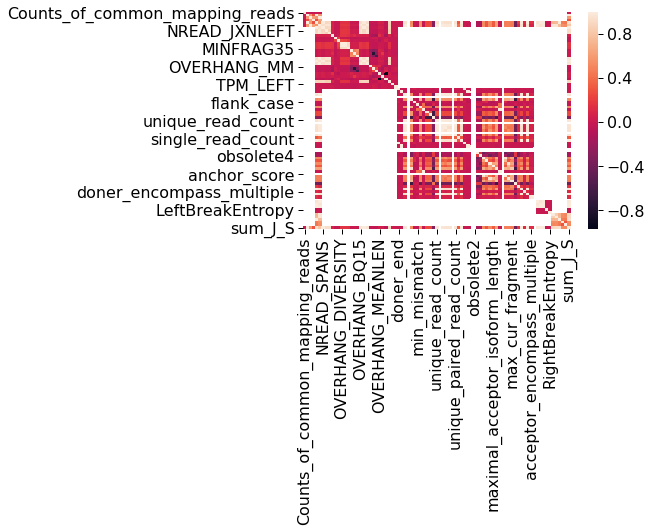

In [66]:
rcParams.update({'figure.autolayout': False})
sns.heatmap(correlation_matrix)

In [137]:
data = [1]
[1 if len(data) > 0 else 0]

[1]